In [1]:
PATH_TO_DIR_WITH_DICOM_FILES = ""

In [1]:
import numpy as np
from monai.transforms import (
    Compose, LoadImaged, Spacingd, Orientationd, ScaleIntensityRanged,
    CropForegroundd, RandFlipd, RandRotate90d, RandGaussianNoised,
    RandAdjustContrastd, RandShiftIntensityd, RandCoarseDropoutd,
    EnsureTyped, ToTensord, RandAffined, ResizeWithPadOrCropd, RandCropByPosNegLabeld
)
from monai.transforms import Transform
from monai.data import MetaTensor
import torch.nn.functional as F
import copy

import os
import numpy as np
import pydicom
from monai.transforms import Transform
import torch
from monai.data import MetaTensor

class LoadDicomOrNiiD(Transform):
    """
    Универсальный загрузчик:
      - принимает путь к nii/nii.gz
      - принимает путь к одному dcm файлу
      - принимает путь к папке с dcm файлами (одно исследование)

    Кладёт в data["image"] тензор [C, D, H, W]
    и в data["meta"] словарь с:
      - study_uid
      - series_uid
      - path (путь к файлу или папке)
    """

    def __init__(self, keys=("image",), ensure_channel_first=True):
        self.keys = keys
        self.ensure_channel_first = ensure_channel_first

    def __call__(self, data):
        d = dict(data)
        path = d[self.keys[0]]

        if os.path.isdir(path):
            # === папка с DICOM ===
            dicoms = []
            for f in os.listdir(path):
                dicoms.append(pydicom.dcmread(os.path.join(path, f), stop_before_pixels=False))
            if len(dicoms) == 0:
                raise RuntimeError(f"В папке {path} нет DICOM файлов!")

            # сортируем по InstanceNumber
            dicoms.sort(key=lambda x: int(getattr(x, "InstanceNumber", 0)))

            # собираем 3D массив
            volume = np.stack([ds.pixel_array for ds in dicoms], axis=0).astype(np.int16)

            study_uid = dicoms[0].StudyInstanceUID if hasattr(dicoms[0], "StudyInstanceUID") else None
            series_uid = dicoms[0].SeriesInstanceUID if hasattr(dicoms[0], "SeriesInstanceUID") else None

        elif path.lower().endswith(".dcm"):
            # === одиночный DICOM ===
            ds = pydicom.dcmread(path, stop_before_pixels=False)
            volume = ds.pixel_array[np.newaxis, ...].astype(np.int16)
            study_uid = getattr(ds, "StudyInstanceUID", None)
            series_uid = getattr(ds, "SeriesInstanceUID", None)

        else:
            # === NIfTI === (передаём в стандартный загрузчик MONAI)
            from monai.transforms import LoadImage
            loader = LoadImage(image_only=True, ensure_channel_first=self.ensure_channel_first)
            volume = loader(path)
            study_uid = None
            series_uid = None

        # приведение к float32
        volume = volume.astype(np.float32)

        # добавляем канал
        if self.ensure_channel_first:
            if volume.ndim == 3:  # [D, H, W] → [1, D, H, W]
                volume = volume[np.newaxis, ...]
            elif volume.ndim == 4 and volume.shape[-1] in (1, 3):  # [D, H, W, C]
                volume = np.moveaxis(volume, -1, 0)

        tensor = torch.as_tensor(volume.copy())
        meta = {
            "study_uid": study_uid,
            "series_uid": series_uid,
            "path": path
        }
        d[self.keys[0]] = MetaTensor(tensor, meta=meta)
        return d


# --- кастом трансформ для labels ---
class CastLabelsToFloatD(Transform):
    def __call__(self, data):
        if "labels" in data:
            data["labels"] = np.asarray(data["labels"]).astype(np.float32)
        return data
    
class RemapLabelsD(Transform):
    """
    Перемаппинг маски по заданному словарю.
    Ожидает маску с int значениями [1..168].
    """
    def __init__(self, mapping, key="mask"):
        """
        mapping: dict {старый_id: новый_id или None}
                 если None → класс удаляется (становится 0)
        """
        self.mapping = mapping
        self.key = key

    def __call__(self, data):
        if self.key in data:
            mask = data[self.key]

            # если это MetaTensor
            if isinstance(mask, MetaTensor):
                meta = dict(mask.meta) if mask.meta is not None else {}
                arr = mask.as_tensor().cpu().numpy()
            else:
                meta = {}
                arr = np.asarray(mask, dtype=np.int32)

            # делаем ремап
            new_arr = np.zeros_like(arr, dtype=np.int32)
            for old_id, new_id in self.mapping.items():
                if new_id is None:
                    continue
                new_arr[arr == old_id] = new_id

            # конвертируем обратно в MetaTensor
            new_tensor = torch.as_tensor(new_arr, dtype=torch.int32)
            if meta:
                new_tensor = MetaTensor(new_tensor, meta=meta)

            data[self.key] = new_tensor
        return data

class AddGlobalResized(Transform):
    """
    Создаёт уменьшенную копию всего скана и кладёт её под новый ключ.
    """
    def __init__(self, source_key="image", target_key="global", size=96):
        self.source_key = source_key
        self.target_key = target_key
        self.size = size

    def __call__(self, data):
        d = dict(data)
        img = d[self.source_key]
        global_resized = F.interpolate(
            img.unsqueeze(0), size=(self.size, self.size, self.size),
            mode="trilinear", align_corners=False
        ).squeeze(0)  # [C, size, size, size]
        d[self.target_key] = global_resized
        return d


class AppendGlobalChannel(Transform):
    """
    Добавляет глобальный канал (d["global"]) к каждому кропу d["image"].
    Работает и если RandCrop вернул список словарей.
    """
    def __init__(self, image_key="image", global_key="global"):
        self.image_key = image_key
        self.global_key = global_key

    def _add_channel(self, d):
        d = dict(d)
        patch_img = d[self.image_key]
        global_resized = d[self.global_key]
        # конкат по каналам
        d[self.image_key] = torch.cat([patch_img, global_resized], dim=0)
        return d

    def __call__(self, data):
        if isinstance(data, list):
            return [self._add_channel(d) for d in data]
        return self._add_channel(data)

class KeepOnlyKeys(Transform):
    """
    В конце пайплайна оставляет только нужные ключи.
    По умолчанию: image и mask.
    """
    def __init__(self, keys=("image", "mask")):
        self.keys = keys

    def __call__(self, data):
        d = dict(data)
        return {k: d[k] for k in self.keys if k in d}
    
# ----------------- Параметры -------------------
TARGET_SPACING = (1.0, 1.0, 1.0)   # mm
TARGET_SIZE = (512, 512, 512)      # для валида и инференса
HU_MIN, HU_MAX = -1000.0, 400.0    # окно легких

"""
Пайплайн для инференса:
- Загружает скан и маску (если есть, например при валидации).
- Приводит spacing и ориентацию к стандарту.
- Масштабирует интенсивности в [0..1].
- Ресайзит объём до фиксированного размера.
- Создаёт глобальную копию (уменьшенную).
- Добавляет глобальный канал к изображению.
- В конце оставляет только ключи image + global (+ mask при наличии).
"""
inference_transforms = Compose([
    LoadDicomOrNiiD(keys=["image"], ensure_channel_first=True),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=TARGET_SPACING, mode="bilinear"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=HU_MIN, a_max=HU_MAX,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    EnsureTyped(keys=["image"]),
    ResizeWithPadOrCropd(keys=["image"], spatial_size=TARGET_SIZE),
    AddGlobalResized(source_key="image", target_key="global", size=96),
    ToTensord(keys=["image", "global"]),
    KeepOnlyKeys(keys=("image", "global"))
])


/home/jupyter/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
2025-10-01 14:30:52.723847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 14:30:57.594568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
import torch.nn.functional as F

def custom_sliding_segmentation(model, volume, global_, roi_size=(96,96,96), overlap=0.25, device="cuda", out_channels=43):
    """
    Скользящее окно для обработки 3D-объёма (например, КТ) с помощью SwinUNETR-модели.
    Работает в два этапа:
      1) Для каждого патча получает эмбеддинги из энкодеров (как раньше).
      2) Прогоняет патчи через декодеры и собирает финальную сегментацию.
    
    Аргументы:
        model (torch.nn.Module): обученная SwinUNETR-модель
        volume (torch.Tensor): входной 3D объём [B, C, D, H, W]
        global_ (torch.Tensor): глобальные признаки, конкатенируются к каждому патчу [B, Cg, D, H, W]
        roi_size (tuple): размер окна (d, h, w)
        overlap (float): доля перекрытия между окнами (0.0–0.9)
        device (str): устройство для вычислений ("cuda" или "cpu")

    Возвращает:
        seg_full (torch.Tensor): собранное сегментированное изображение [B, num_classes, D, H, W]
        embeddings (torch.Tensor): эмбеддинги патчей [num_patches, feat_dim]
    """

    _, _, D, H, W = volume.shape
    d, h, w = roi_size

    stride_d = int(d * (1 - overlap))
    stride_h = int(h * (1 - overlap))
    stride_w = int(w * (1 - overlap))

    # Инициализация пустых тензоров для финальной карты предсказаний и счётчика наложений
    seg_full = torch.zeros((1, out_channels, D, H, W), device=device)
    norm_map = torch.zeros_like(seg_full)

    embeddings = []

    with torch.no_grad():
        for z in range(0, D, stride_d):
            for y in range(0, H, stride_h):
                for x in range(0, W, stride_w):
                    zz, yy, xx = min(z, D - d), min(y, H - h), min(x, W - w)

                    # Вырезаем патч
                    patch = volume[:, :, zz:zz+d, yy:yy+h, xx:xx+w]
                    patch = torch.cat([patch, global_], dim=1).to(device)

                    # ---------- ЭНКОДЕРЫ ----------
                    hidden_states = model.swinViT(patch)
                    enc0 = model.encoder1(patch)             # low-level
                    enc1 = model.encoder2(hidden_states[0])
                    enc2 = model.encoder3(hidden_states[1])
                    enc3 = model.encoder4(hidden_states[2])
                    enc4 = model.encoder10(hidden_states[4])

                    # ---------- ЭМБЕДДИНГИ ----------
                    pooled = [
                        enc0.mean(dim=[2,3,4]),
                        enc1.mean(dim=[2,3,4]),
                        enc2.mean(dim=[2,3,4]),
                        enc3.mean(dim=[2,3,4]),
                        enc4.mean(dim=[2,3,4]),
                    ]
                    concat = torch.cat(pooled, dim=-1)   # [B, feat_dim]
                    embeddings.append(concat.cpu())

                    # ---------- ДЕКОДЕРЫ ----------
                    dec4 = model.decoder5(enc4, hidden_states[3])       # skip connection
                    dec3 = model.decoder4(dec4, enc3)
                    dec2 = model.decoder3(dec3, enc2)
                    dec1 = model.decoder2(dec2, enc1)
                    dec0 = model.decoder1(dec1, enc0)

                    out_patch = model.out(dec0)  # финальный слой классификатора
                    out_patch = F.softmax(out_patch, dim=1)

                    # ---------- СБОРКА ----------
                    seg_full[:, :, zz:zz+d, yy:yy+h, xx:xx+w] += out_patch
                    norm_map[:, :, zz:zz+d, yy:yy+h, xx:xx+w] += 1

                    # Чистим память
                    del patch, hidden_states
                    del enc0, enc1, enc2, enc3, enc4
                    del pooled, concat
                    del dec4, dec3, dec2, dec1, out_patch
                    torch.cuda.empty_cache()

    # Нормализация по количеству наложений
    seg_full /= norm_map
    embeddings = torch.cat(embeddings, dim=0)

    return seg_full, embeddings


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BartForConditionalGeneration, BartTokenizer, BertTokenizer, BertModel
from monai.networks.nets import SwinUNETR
from transformers.modeling_outputs import BaseModelOutput

# === Graph Attention Layer для CLS ===
class SimpleGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1, alpha=0.2):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
        self.a = nn.Linear(2 * out_dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, h):
        B, N, D = h.shape
        Wh = self.W(h)  # [B, N, out_dim]
        Wh_repeat1 = Wh.unsqueeze(2).repeat(1, 1, N, 1)
        Wh_repeat2 = Wh.unsqueeze(1).repeat(1, N, 1, 1)
        e = self.leakyrelu(self.a(torch.cat([Wh_repeat1, Wh_repeat2], dim=-1))).squeeze(-1)
        attn = F.softmax(e, dim=-1)
        attn = self.dropout(attn)
        h_prime = torch.bmm(attn, Wh)
        return h_prime

# === Cross-Attention Bridge ===
class CrossAttentionBridge(nn.Module):
    def __init__(self, embed_dim, bart_dim, num_heads=8, num_cls=18, num_gen=8, dropout=0.1):
        super().__init__()
        self.proj = nn.Linear(embed_dim, bart_dim)
        self.proj_norm = nn.LayerNorm(bart_dim)

        self.cls_queries = nn.Parameter(torch.randn(1, num_cls, bart_dim))
        self.gen_queries = nn.Parameter(torch.randn(1, num_gen, bart_dim))

        self.cross_attn = nn.MultiheadAttention(embed_dim=bart_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(bart_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=bart_dim, nhead=8, batch_first=True, dropout=dropout)
        self.cls_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.gen_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.gat = SimpleGATLayer(bart_dim, bart_dim, dropout=dropout)

    def forward(self, patch_embeddings):
        B = patch_embeddings.size(0)
        patches = self.proj_norm(self.proj(patch_embeddings))

        # CLS поток
        cls_queries = self.cls_queries.expand(B, -1, -1)
        cls_attended, _ = self.cross_attn(query=cls_queries, key=patches, value=patches)
        cls_attended = self.norm(cls_attended + cls_queries)
        cls_attended = self.dropout(cls_attended)
        cls_attended = self.cls_encoder(cls_attended)
        cls_attended = self.gat(cls_attended)

        # GEN поток
        gen_queries = self.gen_queries.expand(B, -1, -1)
        gen_attended, _ = self.cross_attn(query=gen_queries, key=patches, value=patches)
        gen_attended = self.norm(gen_attended + gen_queries)
        gen_attended = self.dropout(gen_attended)
        gen_attended = self.gen_encoder(gen_attended)

        return cls_attended, gen_attended

# === MoE Classifier ===
class MoEClassifier(nn.Module):
    def __init__(self, bart_dim, num_classes=18, num_experts=4, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.num_experts = num_experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(bart_dim, hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim),
                nn.GELU(),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, num_classes)
            )
            for _ in range(num_experts)
        ])
        self.gate = nn.Sequential(nn.Linear(bart_dim, num_experts), nn.Softmax(dim=-1))

    def forward(self, cls_reprs):
        pooled = cls_reprs.mean(dim=1)
        gate_weights = self.gate(pooled)
        expert_outputs = []
        for expert in self.experts:
            out = expert(pooled)
            expert_outputs.append(out.unsqueeze(2))
        expert_outputs = torch.cat(expert_outputs, dim=2)  
        gate_weights = gate_weights.unsqueeze(1)           
        logits = torch.bmm(expert_outputs, gate_weights.transpose(1, 2)).squeeze(-1)
        return logits

# === Coverage Loss ===
def compute_coverage_loss(cross_attentions, eps=1e-8):
    attns = [att.mean(dim=1) for att in cross_attentions]
    attn = torch.stack(attns).mean(dim=0)
    coverage = torch.zeros_like(attn[:, 0, :])
    cov_loss = 0.0
    for t in range(attn.size(1)):
        step_attn = attn[:, t, :]
        cov_loss += torch.sum(torch.min(step_attn, coverage), dim=-1).mean()
        coverage = coverage + step_attn
    return cov_loss / (attn.size(1) + eps)

# === MultiModalMonsterUltimate ===
class MultiModalMonsterUltimate(nn.Module):
    def __init__(self, bart_ckpt="facebook/bart-base", embed_dim=1152, num_classes=18, dropout=0.1,
                 num_experts=4, num_gen_queries=8, lambda_bart=0.2):
        super().__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(bart_ckpt)
        self.tokenizer = BartTokenizer.from_pretrained(bart_ckpt)
        self.bridge = CrossAttentionBridge(embed_dim=embed_dim, bart_dim=self.bart.config.d_model,
                                           num_heads=8, num_cls=num_classes, num_gen=num_gen_queries, dropout=dropout)
        self.classifier = MoEClassifier(bart_dim=self.bart.config.d_model, num_classes=num_classes,
                                        num_experts=num_experts, hidden_dim=512, dropout=dropout)
        self.num_classes = num_classes
        self.lambda_bart = lambda_bart

    def forward(self, embeddings, labels=None, bart_labels=None, classification_loss=None, use_soft_prompt=False,
                tokenizer=None, topk=3, max_report_len=256):
        out = {}
        cls_repr, gen_repr = self.bridge(embeddings)

        # классификация
        logits_cls = self.classifier(cls_repr)
        out["logits_cls"] = torch.sigmoid(logits_cls)

        if labels is not None and classification_loss is not None:
            cls_loss = classification_loss(logits_cls, labels.float())
        else:
            cls_loss = torch.tensor(0.0, device=embeddings.device)

        # генерация
        bart_loss, coverage_loss = torch.tensor(0.0, device=embeddings.device), torch.tensor(0.0, device=embeddings.device)
        enc_out = BaseModelOutput(last_hidden_state=gen_repr)
        if bart_labels is not None:
            bart_out = self.bart(encoder_outputs=enc_out, labels=bart_labels, output_attentions=True, return_dict=True)
            bart_loss = bart_out.loss
            coverage_loss = compute_coverage_loss(bart_out.cross_attentions)
            out["bart_out"] = bart_out
        else:
            generated = self.bart.generate(encoder_outputs=enc_out, max_length=max_report_len, num_beams=4)
            out["bart_out"] = generated
            out["bart_pred"] = self.tokenizer.decode(generated[0], skip_special_tokens=True)

        out["cls_loss"] = cls_loss
        out["bart_loss"] = bart_loss
        out["coverage_loss"] = coverage_loss
        out["loss"] = cls_loss + self.lambda_bart * (bart_loss + coverage_loss)
        return out

# === CheXbert ===
class CheXbert(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_labels=14):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.linear_heads = nn.ModuleList([nn.Linear(hidden_size, 4) for _ in range(num_labels - 1)])
        self.linear_heads.append(nn.Linear(hidden_size, 2))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0, :]
        preds = []
        for head in self.linear_heads:
            preds.append(torch.argmax(torch.softmax(head(cls_emb), dim=1), dim=1).cpu().item())
        return preds

# === Полная модель ===
class Model(nn.Module):
    def __init__(self, bart_ckpt="facebook/bart-base", embed_dim=1152, num_classes=18, dropout=0.1,
                 num_cls_tokens=4, num_prefix_tokens=10, patch_size=(96, 96, 96),
                 in_channels=2, out_channels=43, feature_size=48, img_size=(96, 96, 96), device="cuda"):
        super().__init__()
        self.backbone = SwinUNETR(img_size=img_size, in_channels=in_channels,
                                  out_channels=out_channels, feature_size=feature_size,
                                  use_checkpoint=True).to(device)
        self.out_channels = out_channels
        self.head = MultiModalMonsterUltimate(bart_ckpt=bart_ckpt, embed_dim=embed_dim,
                                              num_classes=num_classes, dropout=dropout).to(device)
        self.device = device
        self.patolog = CheXbert(num_labels=14)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def forward(self, image, global_ctx=None, max_report_len=1024):
        B = image.size(0)
        if global_ctx is None:
            global_ctx = torch.zeros((B, 1, *image.shape[2:]), device=image.device)

        seg, embeddings = custom_sliding_segmentation(
            model=self.backbone, volume=image, global_=global_ctx,
            roi_size=(96, 96, 96), overlap=0.25, device=self.device, out_channels=self.out_channels
        )
        embeddings = embeddings.to(self.device)
        head_out = self.head(embeddings.unsqueeze(0), max_report_len=max_report_len)

        # классификация 14 (CheXbert)
        report_text = head_out.get("bart_pred", "")
        inputs = self.tokenizer(report_text, return_tensors="pt", truncation=True, padding=True)
        logits14 = self.patolog(inputs["input_ids"].to(self.device), inputs["attention_mask"].to(self.device))
        
        CLASS_MAPPING = {
            0: "Пусто",
            1: "Патология обнаружена",
            2: "Патология отсутствует",
            3: "Неопределённо"
        }

        CONDITIONS = [
            'Расширенный кардиомедиастинум',
            'Кардиомегалия (увеличенное сердце)',
            'Затемнение лёгкого',
            'Очаговое поражение лёгкого',
            'Отёк лёгких',
            'Консолидация (уплотнение лёгочной ткани)',
            'Пневмония',
            'Ателектаз (спадение участка лёгкого)',
            'Пневмоторакс (воздух в плевральной полости)',
            'Плевральный выпот',
            'Другие плевральные изменения',
            'Перелом',
            'Медицинские устройства',
            'Без патологий'
        ]

        PTLS = [
            'Медицинский материал',
            'Кальцификация стенки артерии',
            'Кардиомегалия (увеличенное сердце)',
            'Перикардиальный выпот',
            'Кальцификация коронарных артерий',
            'Грыжа пищеводного отверстия диафрагмы',
            'Лимфаденопатия',
            'Эмфизема лёгких',
            'Ателектаз (спадение участка лёгкого)',
            'Лёгочный узел',
            'Затемнение лёгкого',
            'Фиброзные изменения лёгких',
            'Плевральный выпот',
            'Мозаичный рисунок лёгких',
            'Утолщение стенок бронхов',
            'Консолидация (уплотнение лёгочной ткани)',
            'Бронхоэктазы',
            'Утолщение междольковых перегородок'
        ]

        patologos = []
        for i in range(len(logits14)):
            patologos.append({CONDITIONS[i]: CLASS_MAPPING[logits14[i]]})

        pat18 = []
        for i, val in enumerate(head_out["logits_cls"][0].detach().cpu().numpy().tolist()):
            pat18.append({PTLS[i]: float(val)})
            
        

        return {
            "segmentation": torch.argmax(torch.softmax(seg, dim=1), dim=1)[0].cpu().numpy(),
            "patology18": pat18,
            "report": report_text,
            "patology14": patologos
        }


In [4]:
import os
from monai.data import Dataset, DataLoader
from tqdm import tqdm
import time

def infer(model, root_path, transforms, device="cuda", batch_size=1):
    """
    root_path : str
        Путь к директории, внутри которой лежат подпапки с исследованиями (DICOM или NIfTI).
    transforms : monai.transforms.Compose
        Твои трансформы для инференса.
    model : torch.nn.Module
        Твоя модель.
    device : str
        cuda / cpu
    """

    # собираем список исследований
    studies = []
    for item in os.listdir(root_path):
        full_path = os.path.join(root_path, item)
        if (os.path.isdir(full_path) or full_path.lower().endswith((".nii", ".nii.gz", ".dcm"))) and not item.startswith('.'):
            studies.append({"image": full_path})
    print(f"Найдено исследований: {len(studies)}")

    # dataset + dataloader
    dataset = Dataset(data=studies, transform=transforms)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=0)

    results = []
    model.eval()
    model.to(device)

    with torch.no_grad():
        for i, batch in enumerate(loader):
            t = time.time()
            image = batch["image"].to(device)        # [B, C, D, H, W]
            global_ctx = batch.get("global", None)
            if global_ctx is not None:
                global_ctx = global_ctx.to(device)

            # модель вернёт dict
            output = model(image, global_ctx=global_ctx)
            
            # --- вычисляем "норма/патология" ---
            chexbert_preds = output["patology14"]  # список dict'ов (14 классов)
            custom_preds = output["patology18"]    # список dict'ов (18 классов MoE)

            # критерий: есть ли хоть одна положительная патология
            has_pathology_chexbert = any(v in ["Патология обнаружена", "Неопределённо"]
                                         for d in chexbert_preds for v in d.values())
            has_pathology_custom = any(list(d.values())[0] > 0.5 for d in custom_preds)

            if has_pathology_chexbert or has_pathology_custom:
                status = "Патология"
            else:
                status = "Норма"
            # конвертим всё в питоновские типы
            result = {
                "path": batch["image"].meta["path"],
                "study_uid": batch["image"].meta.get("study_uid", None),
                "series_uid": batch["image"].meta.get("series_uid", None),
                "report": output["report"],
                "patology_chexbert": output["patology14"],   # 14 классов CheXbert
                "patology_custom": output["patology18"],    # 18 классов MoE
                "segmentation": output["segmentation"],
                "status": status,
                "image": image[0][0].detach().cpu().numpy(),
                "time": time.time() - t
            }
            results.append(result)
            
            print(f"Обработано {i + 1}/{len(studies)}: {result['path']}")

    return results


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_slice_with_mask(scan, mask, slice_idx=None, alpha=0.4, figsize=(8, 8), cmap="gray", mask_cmap="jet"):
    """
    Отрисовка среза 3D-скана с наложенной маской.
    
    Args:
        scan (torch.Tensor или np.ndarray): [D, H, W] — сам скан
        mask (torch.Tensor или np.ndarray): [D, H, W] — сегментация (int или float)
        slice_idx (int, optional): индекс среза по глубине (ось D). Если None, берём середину.
        alpha (float): прозрачность маски [0..1]
        figsize (tuple): размер картинки
        cmap (str): цветовая карта для скана
        mask_cmap (str): цветовая карта для маски
    """
    if isinstance(scan, torch.Tensor):
        scan = scan.detach().cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    
    D = scan.shape[0]
    if slice_idx is None:
        slice_idx = D // 2

    img_slice = scan[slice_idx]
    mask_slice = mask[slice_idx]

    plt.figure(figsize=figsize)
    plt.imshow(img_slice, cmap=cmap)
    plt.imshow(mask_slice, cmap=mask_cmap, alpha=alpha)
    plt.axis("off")
    plt.title(f"Slice {slice_idx}")
    plt.show()


In [6]:
import os
import pandas as pd
import pydicom
import numpy as np
from datetime import datetime

from pydicom.uid import generate_uid

def save_mask_as_dicom(mask_arr, mask_path, study_uid=None, series_uid=None):
    mask_arr = mask_arr.astype(np.uint16)  # делаем 16-бит
    ds = pydicom.Dataset()
    ds.file_meta = pydicom.dataset.FileMetaDataset()
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    # обязательные поля
    ds.SOPClassUID = generate_uid()
    ds.SOPInstanceUID = generate_uid()
    ds.StudyInstanceUID = study_uid or generate_uid()
    ds.SeriesInstanceUID = series_uid or generate_uid()

    ds.Modality = "SEG"
    ds.Rows, ds.Columns = mask_arr.shape[-2], mask_arr.shape[-1]
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 0  # unsigned
    ds.PixelData = mask_arr.tobytes()

    pydicom.filewriter.dcmwrite(mask_path, ds, write_like_original=False)
    return mask_path


def save_results_to_excel(results, out_xlsx="results.xlsx", masks_dir="masks"):
    os.makedirs(masks_dir, exist_ok=True)
    rows = []

    for res in results:
        path = res.get("path")
        study_uid = res.get("study_uid", "")
        series_uid = res.get("series_uid", "")
        report = res.get("report", "")
        pathology_chx = res.get("patology_chexbert", [])
        pathology_custom = res.get("patology_custom", [])
        seg = res.get("segmentation")
        time_proc = res.get("time", None)

        # === вероятность патологии и бинарный флаг ===
        # если хоть одна патология найдена → 1, иначе → 0
        has_pathology = 0
        prob_path = 0.0

        # фильтруем CheXbert только по Positive
        chex_findings = [list(p.keys())[0] for p in pathology_chx if list(p.values())[0] == "Positive"]

        # фильтруем кастом по threshold > 0.5
        custom_findings = [list(p.keys())[0] for p in pathology_custom if list(p.values())[0] > 0.5]

        if len(chex_findings) > 0 or len(custom_findings) > 0:
            has_pathology = 1
            prob_path = 1.0

        # === сохраняем сегментацию в DICOM ===
        mask_path = ""
        if seg is not None:
            mask_arr = seg.astype(np.int16)
            mask_path = os.path.join(masks_dir, f"{study_uid[0]}_{series_uid[0]}_mask.dcm")
            save_mask_as_dicom(mask_arr, mask_path, study_uid[0], series_uid[0])


        # === собираем строку для таблицы ===
        row = {
            "path_to_study": path[0],
            "study_uid": study_uid[0],
            "series_uid": series_uid[0],
            "probability_of_pathology": prob_path,
            "pathology": has_pathology,
            "processing_status": "Success",
            "time_of_processing": float(time_proc) if time_proc else None,
            "report": report,
            "chexbert_findings": ", ".join(chex_findings) if chex_findings else "",
            "custom_findings": ", ".join(custom_findings) if custom_findings else "",
            "segmentation": mask_path
        }
        rows.append(row)

    # === пишем в Excel ===
    df = pd.DataFrame(rows)
    df.to_excel(out_xlsx, index=False)
    print(f"[+] Сохранено в {out_xlsx}, всего записей: {len(df)}")


In [7]:
device = torch.device('cuda')

In [8]:
model = Model().to(device)

In [9]:
model.load_state_dict(torch.load('model2.pth'))

<All keys matched successfully>

In [11]:
out = infer(model, 'example_dataset/', inference_transforms)

Найдено исследований: 3
Обработано 1/3: ['example_dataset/norma_anon']
Обработано 2/3: ['example_dataset/pneumonia_anon']
Обработано 3/3: ['example_dataset/pneumotorax_anon']


In [12]:
save_results_to_excel(out)

[+] Сохранено в results.xlsx, всего записей: 3


In [13]:
df = pd.read_excel('results.xlsx')
df

,path_to_study,study_uid,series_uid,probability_of_pathology,pathology,processing_status,time_of_processing,report,chexbert_findings,custom_findings,segmentation
0,example_dataset/norma_anon,1.2.276.0.7230010.3.1.2.2462171185.19116.17545...,1.2.276.0.7230010.3.1.3.2462171185.19116.17545...,1,1,Success,41.887628,"Trachea, both main bronchi are open. Mediastin...",NaN,"Медицинский материал, Затемнение лёгкого",masks/1.2.276.0.7230010.3.1.2.2462171185.19116...
1,example_dataset/pneumonia_anon,1.2.276.0.7230010.3.1.2.2462171185.19116.17545...,1.2.276.0.7230010.3.1.3.2462171185.19116.17545...,1,1,Success,38.432268,Trachea and both main bronchi are open. Medias...,NaN,"Медицинский материал, Ателектаз (спадение учас...",masks/1.2.276.0.7230010.3.1.2.2462171185.19116...
2,example_dataset/pneumotorax_anon,1.2.276.0.7230010.3.1.2.2462171185.19116.17545...,1.2.276.0.7230010.3.1.3.2462171185.19116.17545...,1,1,Success,39.128085,"Trachea, both main bronchi are open. Mediastin...",NaN,Эмфизема лёгких,masks/1.2.276.0.7230010.3.1.2.2462171185.19116...


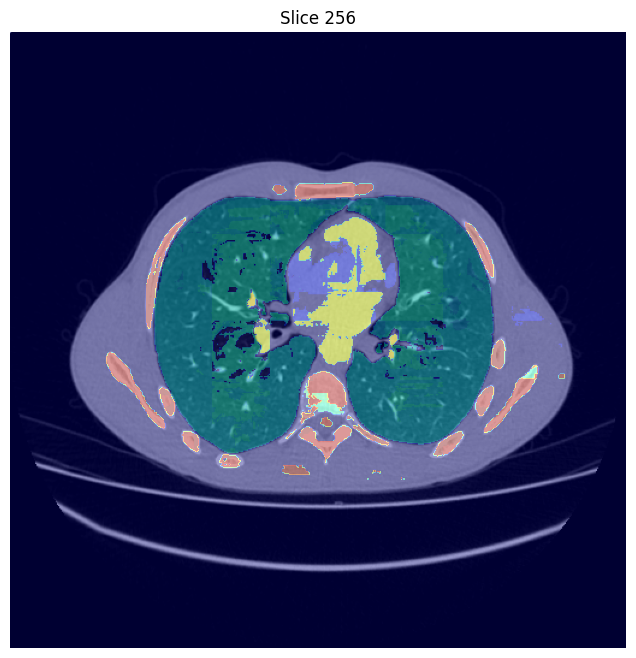

In [14]:
plot_slice_with_mask(out[0]['image'], out[0]['segmentation'])